## Data Analysis

In this notebook, we use the Green Metric Tool API to analyse the measurements collected during simulated email user sessions. This involves processing and interpreting data related to energy consumption of basic email operations, called functional units, across different providers, assessing performance metrics, and comparing the impact of different factors such as ad-blockers and PGP encryption.


#### Load the libraries

In [57]:
import pandas as pd # For data manipulation
import numpy as np # For data manipulation
import requests # For HTTP Requests to the API
import seaborn as sns # For charts
from IPython.display import display # To dataframe displaying
import scipy.stats as stats # For stats
import pingouin as pg # For stats
from itertools import combinations
import matplotlib.pyplot as plt
from datetime import datetime, timezone

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

#Set display options to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-detect the width
pd.set_option('display.max_colwidth', None)  # Show full content of each column

# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')
# pd.reset_option('display.width')
# pd.reset_option('display.max_colwidth')

#### Define the URL and other constants to query the GMT API

In [58]:
URL = 'http://api.green-coding.internal:9142'
REPO = '/home/jason/memoire/simulator'
RUNS = '/v1/runs'
NOTES = '/v1/notes/'
MEASUREMENTS = '/v1/measurements/single/'

### Define functions to:
    - get all the runs infos (test_name, run_ids, time)
    - get all run ids of tests which names include a substring
    - get the test name of a given run id
    - get the notes from a given run id
    - print the logs of a given run id
    - get the measurment of a given run id

In [59]:
# Function to get all runs
def get_runs():
    try:
        # Fetch data from the API
        response = requests.get(URL + RUNS)
        response.raise_for_status()  # Check if the request was successful
        
        data = response.json()
        
        # Convert the relevant part of the data into a DataFrame
        runs = pd.DataFrame.from_dict(data['data'])
        runs = runs[[0, 1, 4]]
        runs.columns = ['id', 'name', 'time']
        # Convert the 'time' column (containing UTC timestamp strings) to UTC timestamps
        runs['time'] = pd.to_datetime(runs['time'])
        
        return runs
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as e:
        print(f"Failed to decode JSON: {e}")

# Function to get all the run IDs for a test name containing a given substring
def get_ids(substring="", time=False):
    runs = get_runs()
    filtered_runs = runs[runs['name'].str.contains(substring, na=False)]
    if time:
        return filtered_runs['id'].tolist(), filtered_runs['time'].tolist()
    return filtered_runs['id'].tolist()

# Function to get the test name of a run given its ID
def get_name(id):
    runs = get_runs()
    run = runs[runs['id'] == id]
    
    if not run.empty:
        return run.iloc[0]['name']
    else:
        return None

# Function to create the notes (i.e., logs) DataFrame from an ID
def get_notes(id):
    try:
        response = requests.get(URL + NOTES + id)
        response.raise_for_status()  # Check if the request was successful
        data = response.json()
        notes = pd.DataFrame.from_dict(data['data'])
        
        # Set the appropriate column names
        notes.columns = ['id', 'container', 'log', 'time']

        # Sort the logs by time
        notes.sort_values(by='time', ascending=False, inplace=True)
        
        return notes
        
    except Exception as e:
        print(f"Failed to fetch or process notes for ID {id}: {e}")
        # Return an empty DataFrame with the expected column names
        return pd.DataFrame(columns=['id', 'container', 'log', 'time'])

def print_logs(id):
    # print the notes (logs) for the given ID
    notes_df = get_notes(id)
    
    if notes_df.empty:
        print(f"No logs found for ID {id}.")
        return
    
    # Print the logs in order
    for index, row in notes_df.iterrows():
        print(f"Time: {row['time']}, Log: {row['log']}")


# Function to get the measurement DataFrame from an ID
def get_measurements(id):
    try:
        response = requests.get(URL + MEASUREMENTS + id)
        response.raise_for_status()  # Check if the request was successful
        data = response.json()
        measurement = pd.DataFrame.from_dict(data['data'])
        
        # Set the appropriate column names
        measurement.columns = ['detail_name', 'time', 'metric', 'value', 'unit']
        return measurement

    except Exception as e:
        print(f"Failed to fetch measurements for ID {id}: {e}")
        # Return an empty DataFrame in case of an error
        return pd.DataFrame(columns=['detail_name', 'time', 'metric', 'value', 'unit'])

### Define a DataFrame to Map Providers and Functional Units to corresponding Tests and Actions to Monitor

We use a DataFrame to map each (provider, functional unit) pair to the test containing the samples and the action to monitor within those test.

EXAMPLE :  
- Considering the 'reply' functional unit for the 'gmail' provider with adblock enabled, we look up the entry `['gmail_adblock', 'repy']`. This entry directs us to the test name `'2025_gmail_answer_adblock.json'` and specifies the name of the action to monitor: `'reply'`.

- Considering the 'attachment' functional unit (i.e. send with attachment file) for the 'mysolution' provider with adblock disabled and PGP enabled, we look up the entry `['mysolution_noadblock_pgp', 'attachment']`. This entry directs us to the test name `'2025_mysolution_attachment_noadblock_pgp.json'` and specifies the name of the action to monitor: `'send_mail'`.


In [60]:
ADBLOCK_CONDITION = ['enabled', 'disabled']
FUNCTIONAL_UNITS =     [
                        'google',
                        'yahoo',  
                        'bing',
                        'wikipedia',
                        'weather',
                        'cnn',
                        'foxnews',
                        'nytimes',
                        'sohu',
                        'taobao']

def get_test_name_and_action(adblock, functional_unit):
    test_name = "topnews_"
    action = None
    test_name += 'adblock' if adblock == 'enabled' else 'noadblock'

    if functional_unit == 'session':
        action = 'session'
    elif functional_unit == 'google':
        action = 'surf_to_' + 'https://google.com'
    elif functional_unit == 'yahoo':
        action = 'surf_to_' + 'https://yahoo.com'
    elif functional_unit == 'bing':
        action = 'surf_to_' + 'https://bing.com'
    elif functional_unit == 'wikipedia':
        action = 'surf_to_' + 'https://wikipedia.org'
    elif functional_unit == 'weather':
        action = 'surf_to_' + 'https://weather.com'
    elif functional_unit == 'cnn':
        action = 'surf_to_' + 'https://cnn.com'
    elif functional_unit == 'foxnews':
        action = 'surf_to_' + 'https://foxnews.com'
    elif functional_unit == 'nytimes':
        action = 'surf_to_' + 'https://nytimes.com'
    elif functional_unit == 'sohu':
        action = 'surf_to_' + 'https://sohu.com'
    elif functional_unit == 'taobao':
        action = 'surf_to_' + 'https://taobao.com'


    return test_name, action
    

# Generate all combinations of provider, adblock, pgp, and functional_unit
tests_and_actions = [
    [adblock, functional_unit] + list(get_test_name_and_action(adblock, functional_unit))
    for adblock in ADBLOCK_CONDITION
    for functional_unit in FUNCTIONAL_UNITS
]

# Create the DataFrame
TESTS_AND_ACTIONS = (pd.DataFrame(tests_and_actions, columns=['ADBLOCK_CONDITION', 'FUNCTIONAL_UNIT', 'TEST', 'ACTION']) \
    .set_index(['ADBLOCK_CONDITION', 'FUNCTIONAL_UNIT']))


TESTS_AND_ACTIONS

TEST  \
ADBLOCK_CONDITION FUNCTIONAL_UNIT                      
enabled           google             topnews_adblock   
                  yahoo              topnews_adblock   
                  bing               topnews_adblock   
                  wikipedia          topnews_adblock   
                  weather            topnews_adblock   
                  cnn                topnews_adblock   
                  foxnews            topnews_adblock   
                  nytimes            topnews_adblock   
                  sohu               topnews_adblock   
                  taobao             topnews_adblock   
disabled          google           topnews_noadblock   
                  yahoo            topnews_noadblock   
                  bing             topnews_noadblock   
                  wikipedia        topnews_noadblock   
                  weather          topnews_noadblock   
                  cnn              topnews_noadblock   
                  foxnews          topnews_noadblock   
                  nytimes          topnews_noadblock   
                  sohu             topnews_noadblock   
                  taobao           topnews_noadblock   

                                                          ACTION  
ADBLOCK_CONDITION FUNCTIONAL_UNIT                                 
enabled           google              surf_to_https://google.com  
                  yahoo                surf_to_https://yahoo.com  
                  bing                  surf_to_https://bing.com  
                  wikipedia        surf_to_https://wikipedia.org  
                  weather            surf_to_https://weather.com  
                  cnn                    surf_to_https://cnn.com  
                  foxnews            surf_to_https://foxnews.com  
                  nytimes            surf_to_https://nytimes.com  
                  sohu                  surf_to_https://sohu.com  
                  taobao              surf_to_https://taobao.com  
disabled          google              surf_to_https://google.com  
                  yahoo                surf_to_https://yahoo.com  
                  bing                  surf_to_https://bing.com  
                  wikipedia        surf_to_https://wikipedia.org  
                  weather            surf_to_https://weather.com  
                  cnn                    surf_to_https://cnn.com  
                  foxnews            surf_to_https://foxnews.com  
                  nytimes            surf_to_https://nytimes.com  
                  sohu                  surf_to_https://sohu.com  
                  taobao              surf_to_https://taobao.com

# Metadata Collection and Sample Counting

We want to collect metadata related to energy measurements for different **providers** and **functional units**. It includes the following steps:

- **`collect_metadata`**: Fetches metadata for a specific provider and functional unit, including start and end timestamps.
- **`collect_all_metadata`**: Collects metadata for all providers and functional units.

We also want to monitor the number of valid samples we have so far. We define:

- **`count_distinct_samples`**: Counts valid and missing samples based on unique start and end timestamps.


In [61]:

def collect_metadata(adblock, functional_unit, test_name, action, from_date=None, till_date=None):
    """
    Collect metadata required to fetch energy measurements.
    This includes gathering the run ID and the time period when a functional unit was performed.
    A period is considered valid if no error occurred during the functional unit execution.

    Args:
        provider (str): The provider for which metadata is being collected.
        adblock (str): The adblock condition: enabled/disabled.
        pgp (str): The pgp condition: enabled/disabled.
        functional_unit (str): The functional unit to monitor.
        test_name (str): The name of the test which perform the functional units for the provider under given adblock/pgp conditions.
        action (str): The action that triggers the start/end logs.
        from_date (str, optional): Start date in 'dd-mm-yyyy' format. If None, no start limit is applied.
        till_date (str, optional): End date in 'dd-mm-yyyy' format. If None, no end limit is applied.

    Returns:
        pd.DataFrame: A DataFrame containing metadata with columns:
                      ['TEST', 'RUN_ID', 'PROVIDER', 'ADBLOCK_CONDITION', 'PGP_CONDITION', 
                       'FUNCTIONAL_UNIT', 'START_TS', 'END_TS'].
    """
    
    columns = ['TEST', 'RUN_ID','ADBLOCK_CONDITION', 'FUNCTIONAL_UNIT', 'START_TS', 'END_TS']
    metadata_records = []  # List to store metadata records
    ids, timestamps = get_ids(test_name, time=True)  # Fetch the test run IDs and their corresponding timestamps

    for run_id, run_timestamp in zip(ids, timestamps, strict=True):

        # Check if the timestamp fits within the date range (if provided)
        if from_date and run_timestamp < pd.to_datetime(from_date, format="%d-%m-%Y", utc=True):
            continue  # Skip records that are before the 'from' time
        if till_date and run_timestamp > pd.to_datetime(till_date, format="%d-%m-%Y", utc=True):
            continue  # Skip records that are after the 'till' time

        logs = get_notes(run_id)  # Get logs for the run
        end_log_time = None  # Variable to track the latest "END" log timestamp

        for _, row in logs.iterrows():
            log_message = row['log']
            timestamp = row['time']

            # Detect end log for the specific action
            if f"END: {action}" in log_message:
                end_log_time = timestamp
                continue

            # Invalidate end time if there's an error during action execution
            if 'ERROR' in log_message or 'stacktrace' in log_message:
                end_log_time = None
                continue

            # Collect metadata once a valid start-end pair is found
            if f"START: {action}" in log_message and end_log_time is not None:
                metadata_records.append((test_name, run_id, adblock, functional_unit, timestamp, end_log_time))
                end_log_time = None  # Reset after recording
    
    return pd.DataFrame(metadata_records, columns=columns)



def collect_all_metadata(from_date=None, till_date=None):
    """
    Collect metadata for all providers and functional units.
    """
    metadata_list = [
        collect_metadata(adblock, functional_unit, row['TEST'], row['ACTION'], from_date, till_date)
        for (adblock, functional_unit), row in TESTS_AND_ACTIONS.iterrows()
    ]

    return pd.concat(metadata_list, ignore_index=True,)

def count_distinct_samples(metadata: pd.DataFrame):
    """
    Count the number of valid samples for each (provider, functional_unit) combination.
    A valid sample is defined as a unique pair of start and end timestamps for each (TEST, ACTION).

    Args:
        metadata (pd.DataFrame): The metadata DataFrame to count samples from.

    Returns:
        pd.DataFrame: A DataFrame containing the sample counts and missing sample counts.
    """
    return (metadata.groupby(['ADBLOCK_CONDITION', 'FUNCTIONAL_UNIT'])
                .agg(SAMPLE_COUNT=('START_TS', 'count'), 
                    MISSING_SAMPLES=('START_TS', lambda x: max(0, 100 - x.count())))  # Count missing samples
            )

In [62]:
# Collect the full metadata DataFrame
# Tests performed in Switzerland on a ethernet link connection : '25-02-2025 - 27-02-2025'

metadata = collect_all_metadata(from_date='25-02-2025')

# Count distinct test-action pairs for the metadata
count_distinct_samples(metadata)


SAMPLE_COUNT  MISSING_SAMPLES
ADBLOCK_CONDITION FUNCTIONAL_UNIT                               
disabled          bing                      154                0
                  cnn                       154                0
                  foxnews                   154                0
                  google                    154                0
                  nytimes                   154                0
                  sohu                      153                0
                  taobao                    154                0
                  weather                   154                0
                  wikipedia                 154                0
                  yahoo                     154                0
enabled           bing                      171                0
                  cnn                       171                0
                  foxnews                   171                0
                  google                    171                0
                  nytimes                   171                0
                  sohu                      171                0
                  taobao                    171                0
                  weather                   171                0
                  wikipedia                 171                0
                  yahoo                     171                0

### Create DataFrames for Each Metric

In this section, we will generate a DataFrame for each metric listed in the METRICS list. Each DataFrame is structured with providers as rows and actions as columns. The cells contain lists of measurement values collected from multiple runs.

In [63]:
# First we check which metric we have at our disposal
test_id = get_ids("topnews")[0]
print(get_measurements(test_id)[['metric', 'unit']].drop_duplicates())

                                 metric   unit
0         cpu_energy_rapl_msr_component     mJ
1881   cpu_utilization_cgroup_container  Ratio
3514      cpu_utilization_procfs_system  Ratio
5394   memory_energy_rapl_msr_component     mJ
7275      memory_total_cgroup_container  Bytes
8913        network_io_cgroup_container  Bytes
10549     psu_energy_ac_xgboost_machine     mJ


In [64]:
METRICS = [
    'CPU_ENERGY',                   # cpu_energy_rapl_msr_component
    'MEMORY_ENERGY',                # memory_energy_rapl_msr_component
    'NETWORK_IO',                   # network_io_cgroup_container
    'ESTIMATED_MACHINE_ENERGY',     # psu_energy_ac_xgboost_machine
    'DURATION']

COMPUTED_METRICS = ['CPU_POWER',
                    'MEMORY_POWER',
                    'ESTIMATED_MACHINE_POWER']
UNITS = {
    'CPU_ENERGY': 'mJ',
    'MEMORY_ENERGY': 'mJ',
    'NETWORK_IO' : 'Byte',
    'ESTIMATED_MACHINE_ENERGY' : 'mJ',
    'DURATION' : 'µs',
    'CPU_POWER' : 'W',
    'MEMORY_POWER' : 'W',
    'ESTIMATED_MACHINE_POWER' : 'W'
}

### Collect and Organise Metric Data into a Single DataFrame

**Gathering Measurement Data:**

In the `get_data` function, we collect measurement data for each sample in the `metadata` DataFrame. We extract key metadata, including test names, run IDs, provider names, adblock conditions, pgp condition, functional units, and the start and end timestamps for each sample. For each time period, we then compute the energy-related metrics—such as memory energy, CPU energy, estimated machine energy, and network I/O—using the `get_metric_stat` function.

**Storing the Collected Data:**

We store the computed values in a DataFrame. The columns of this DataFrame are: `TEST`, `RUN_ID`, `PROVIDER`, `FUNCTIONAL_UNIT`, `START_TS`, `DURATION`, `MEMORY_ENERGY`, `CPU_ENERGY`, `ESTIMATED_MACHINE_ENERGY`, and `NETWORK_IO`.

By bringing all the metric values together in one DataFrame, we make it easier to export the data to a CSV file and reload it later for further analysis. This approach ensures we don’t need to recompute the metrics every time we need the data.


In [65]:
def get_metric_stat(measurements, metric, start_ts, end_ts, func):

    # Filter to keep records of the desired metric
    measurements = measurements[measurements['metric'] == metric]
    # Filter to keep records in desired period
    measurements = measurements[(measurements['time'] >= start_ts) & (measurements['time'] < end_ts)]
    # Compute the statistic
    stat = func(measurements['value'])

    return stat

def get_data(metadata:pd.DataFrame):

    data_records = []  # Store tuples for DataFrame creation

    for run_id, run_metadata in metadata.groupby('RUN_ID') :

        # Get measurment for the run
        run_measurements = get_measurements(run_id)
        run_measurements.sort_values(by='time', ascending=True, inplace=True)

        for _, row in run_metadata.iterrows():

            # Extract Metadata:
            test = row['TEST']
            adblock_condition = row['ADBLOCK_CONDITION'] 
            functional_unit = row['FUNCTIONAL_UNIT']
            start_ts = row['START_TS']
            end_ts = row['END_TS']
            duration = end_ts - start_ts

            # Compute Data
            memory_energy = get_metric_stat(run_measurements, 'memory_energy_rapl_msr_component', start_ts, end_ts, sum)
            cpu_energy = get_metric_stat(run_measurements, 'cpu_energy_rapl_msr_component', start_ts, end_ts, sum)
            estimated_machine_energy = get_metric_stat(run_measurements, 'psu_energy_ac_xgboost_machine', start_ts, end_ts, sum)
            network_io = get_metric_stat(run_measurements, 'network_io_cgroup_container', start_ts, end_ts, lambda x: x.iloc[-1] - x.iloc[0] if len(x) > 1 else 0)

            # Store records
            data_records.append((test,
                                run_id,
                                adblock_condition,
                                functional_unit,
                                start_ts,
                                duration,
                                memory_energy,
                                cpu_energy,
                                estimated_machine_energy,
                                network_io))
        
    data = pd.DataFrame(  columns = ['TEST',
                                    'RUN_ID',
                                    'ADBLOCK_CONDITION',
                                    'FUNCTIONAL_UNIT',
                                    'START_TS',
                                    'DURATION',
                                    'MEMORY_ENERGY',
                                    'CPU_ENERGY',
                                    'ESTIMATED_MACHINE_ENERGY',
                                    'NETWORK_IO'],
                        data = data_records).sort_values(by=['ADBLOCK_CONDITION',
                                                                'FUNCTIONAL_UNIT'])
    return data

In [66]:
data = get_data(metadata=metadata)
data.to_csv('2025_topnews_data.csv', index=False)

# START FROM HERE

In [11]:
data = pd.read_csv('2025_topnews_data.csv')

In [67]:

def remove_outliers(data, columns, group_columns=['ADBLOCK_CONDITION', 'FUNCTIONAL_UNIT']):
    """
    Removes outliers from the dataframe using the IQR method per group (PROVIDER, FUNCTIONAL_UNIT).
    """
    # Iterate over each metric (column)
    for col in columns:
        # Define a function to remove outliers for each group
        def remove_outliers_for_group(group_df):
            Q1 = group_df[col].quantile(0.25)
            Q3 = group_df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            return group_df[(group_df[col] >= lower_bound) & (group_df[col] <= upper_bound)]
        
        # Apply the function to remove outliers for each group
        data = data.groupby(group_columns).apply(remove_outliers_for_group).reset_index(drop=True)
    
    return data

# Columns to remove outliers for
columns_to_check = ['DURATION', 'MEMORY_ENERGY', 'CPU_ENERGY', 'ESTIMATED_MACHINE_ENERGY', 'NETWORK_IO']

# Remove outliers
clean_data = remove_outliers(data, columns=columns_to_check)

# Display the numbers of valid samples left
count_distinct_samples(clean_data)



SAMPLE_COUNT  MISSING_SAMPLES
ADBLOCK_CONDITION FUNCTIONAL_UNIT                               
disabled          bing                      146                0
                  cnn                       143                0
                  foxnews                   118                0
                  google                    110                0
                  nytimes                    99                1
                  sohu                      117                0
                  taobao                    113                0
                  weather                   110                0
                  wikipedia                 109                0
                  yahoo                     144                0
enabled           bing                      159                0
                  cnn                       158                0
                  foxnews                   147                0
                  google                     78               22
                  nytimes                   163                0
                  sohu                      117                0
                  taobao                    118                0
                  weather                   131                0
                  wikipedia                 136                0
                  yahoo                     158                0

In [68]:
# Get specific test samples from data
def get_samples(data,
                functional_unit,
                adblock='disabled',
                metrics=['DURATION', 'MEMORY_ENERGY', 'CPU_ENERGY', 'ESTIMATED_MACHINE_ENERGY', 'NETWORK_IO']):
    
    return data[(data['ADBLOCK_CONDITION'] == adblock) &
                (data['FUNCTIONAL_UNIT'] == functional_unit)][metrics]


# Plot the distribution
def plot_distribution(data,
                      functional_unit,
                      adblock='disabled',
                      metrics=['DURATION', 'MEMORY_ENERGY', 'CPU_ENERGY', 'ESTIMATED_MACHINE_ENERGY', 'NETWORK_IO']):
    
    samples = get_samples(data, functional_unit, adblock, metrics)
    
    # Number of columns in the plot grid (one for each variable to plot)
    num_columns = len(metrics)
    
    # Create a figure with subplots (1 row, multiple columns)
    fig, axes = plt.subplots(1, num_columns, figsize=(16, 6), sharey=True)
    if num_columns == 1:
        axes = [axes]
    
    # Loop over columns and axes to plot the distributions
    for ax, metric in zip(axes, metrics):
        sns.histplot(samples[metric], kde=True, bins=10, ax=ax)
        ax.set_title(f'Distribution of {metric} ({UNITS[metric]})', fontsize=9)
        ax.set_xlabel(metric)
        ax.set_ylabel('Frequency')

    # Set a main title for the figure
    main_title = f'Adblock: {adblock}, Functional Unit: {functional_unit}'
    plt.suptitle(main_title, fontsize=14, fontweight='bold', y=1.05)

    # Adjust layout to avoid overlap
    plt.tight_layout()
    
    # Show the plot
    plt.show()


In [ ]:
for adblock, functional_unit in TESTS_AND_ACTIONS.index:
    plot_distribution(clean_data, functional_unit, adblock)

In [69]:
def get_power_data(data:pd.DataFrame):
    new_columns = ['CPU_POWER', 'MEMORY_POWER', 'ESTIMATED_MACHINE_POWER']
    columns = ['CPU_ENERGY', 'MEMORY_ENERGY', 'ESTIMATED_MACHINE_ENERGY']
    for i in range(len(new_columns)):
        data[new_columns[i]] = (data[columns[i]]/data['DURATION'])

def change_scale(data):
    for metric, unit in UNITS.items():
        if metric in data.columns:
            if unit == 'mJ':
                data[metric] = data[metric]/1e3
                UNITS[metric] = 'J'
            if unit == 'Byte':
                data[metric] = data[metric]/1e6
                UNITS[metric] = 'MB'
            if unit == 'µs':
                data[metric] = data[metric]/1e6
                UNITS[metric] = 's'

                
change_scale(clean_data)
get_power_data(clean_data)

### Define a function to get the means and standard deviation of each test

In [71]:
def compute_means_and_stds(data:pd.DataFrame):

    return data.groupby(['ADBLOCK_CONDITION', 'FUNCTIONAL_UNIT']) \
                .agg({  'DURATION': ['mean', 'std'],
                        'MEMORY_ENERGY': ['mean', 'std'],
                        'CPU_ENERGY': ['mean', 'std'],
                        'ESTIMATED_MACHINE_ENERGY': ['mean', 'std'],
                        'NETWORK_IO': ['mean', 'std'],
                        'MEMORY_POWER': ['mean', 'std'],
                        'CPU_POWER': ['mean', 'std'],
                        'ESTIMATED_MACHINE_POWER': ['mean', 'std'],
                    })


### Define a function to plot the mean results with their standard deviations

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics_bars(means_and_stds: pd.DataFrame, metric: str):

    # Create a new figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Get unique functional units and calculate positions
    functional_units = FUNCTIONAL_UNITS
    num_conditions = len(means_and_stds) // len(functional_units)  # Number of provider-condition combinations per functional unit
    bar_width = 0.8 / num_conditions  # Space bars based on the number of provider-condition combinations
    index = np.arange(len(functional_units))  # Set x-axis positions for the functional units

    # Iterate over each functional unit to plot the bars
    for j, functional_unit in enumerate(functional_units):
        # Extract rows for the current functional unit
        rows = means_and_stds.xs(functional_unit, level='FUNCTIONAL_UNIT')

        # Iterate over the provider/condition combinations for the functional unit
        for i, (idx, row) in enumerate(rows.iterrows()):
            adblock = idx
            mean_value, std_value = row[metric]['mean'], row[metric]['std']

            #Get the appropriate color for the given provider and condition
            if adblock == 'enabled':
                adblock_label = 'adblock'
                color = 'lightblue'
            else:
                adblock_label = 'noadblock'
                color = 'gray'

            # Calculate bar position based on functional unit and provider-condition index
            bar_position = index[j] + i * bar_width

            # Label the first bar of each functional unit with provider/condition info
            label = f'{adblock_label}' if j == 0 else None

            # Plot the bar and add error bars
            ax.bar(bar_position, mean_value, bar_width, edgecolor='k', label=label, color = color)
            ax.errorbar(bar_position, mean_value, yerr=std_value, fmt='o', color='black', capsize=5)
    
    # Set the labels, title, and ticks
    ax.set_xlabel('Functional Units')
    ax.set_ylabel(f'{metric} ({UNITS.get(metric, "")})')
    ax.set_title(f'Mean and Standard Dev of {metric} ({UNITS.get(metric,"")}) by Functional Unit')
    ax.set_xticks(index + bar_width * (num_conditions - 1) / 2)
    ax.set_xticklabels(functional_units)

    # Add the legend
    ax.legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


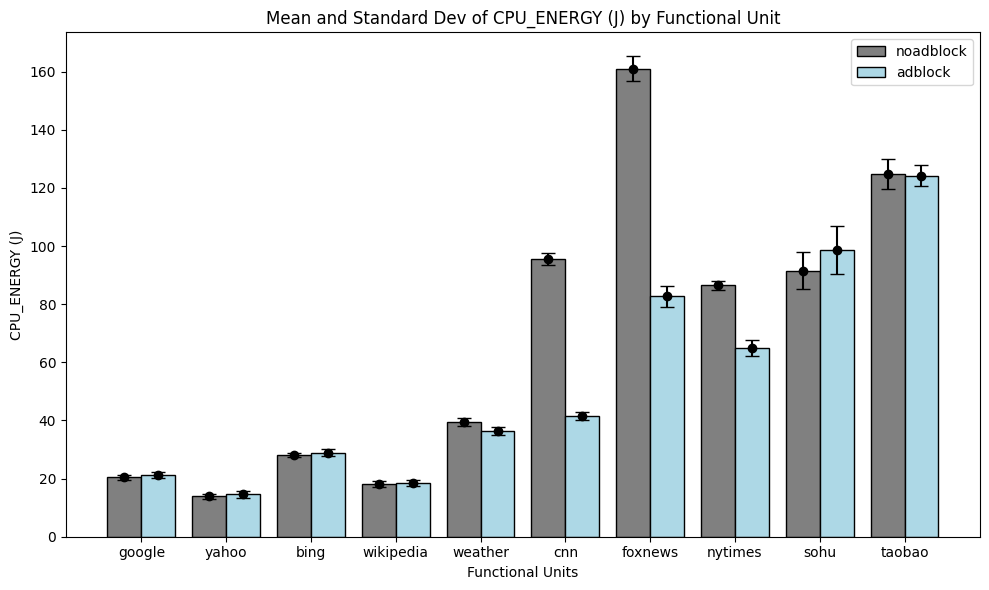

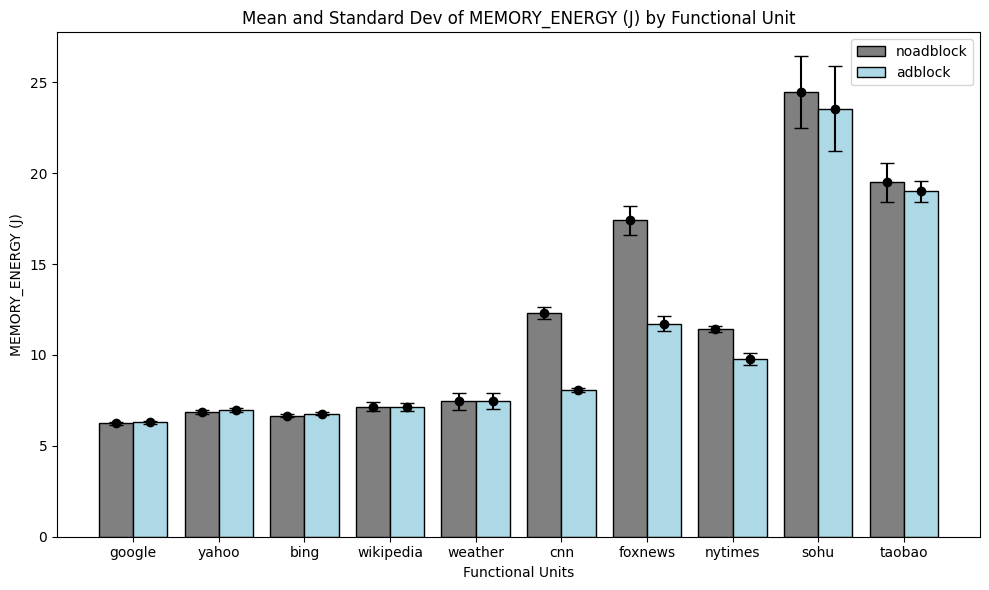

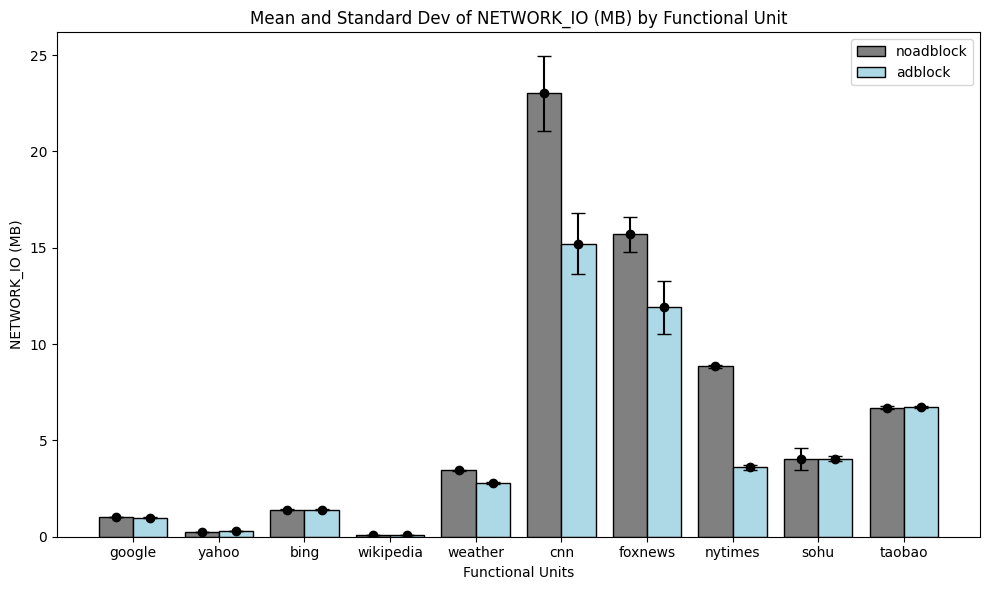

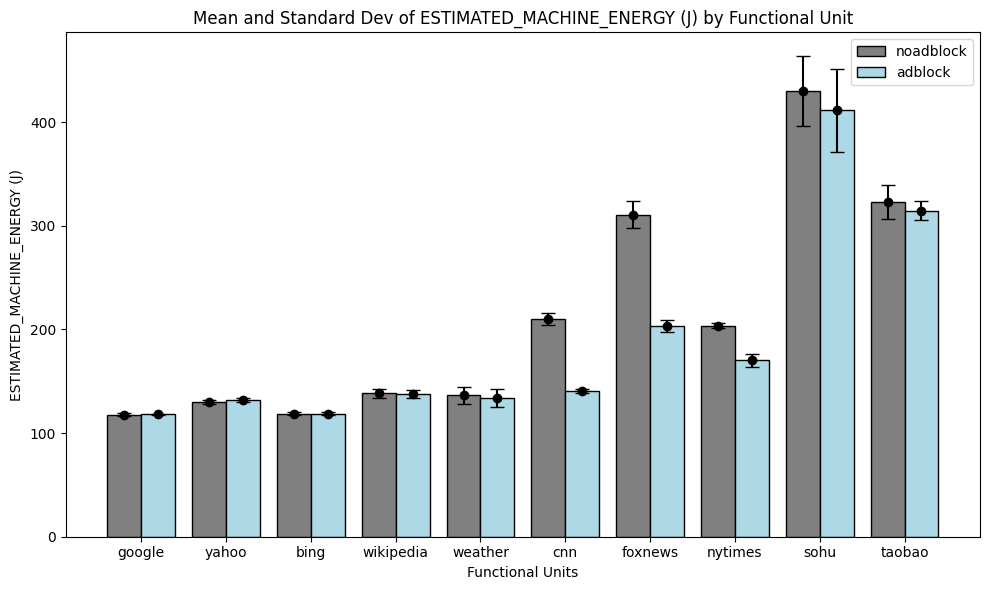

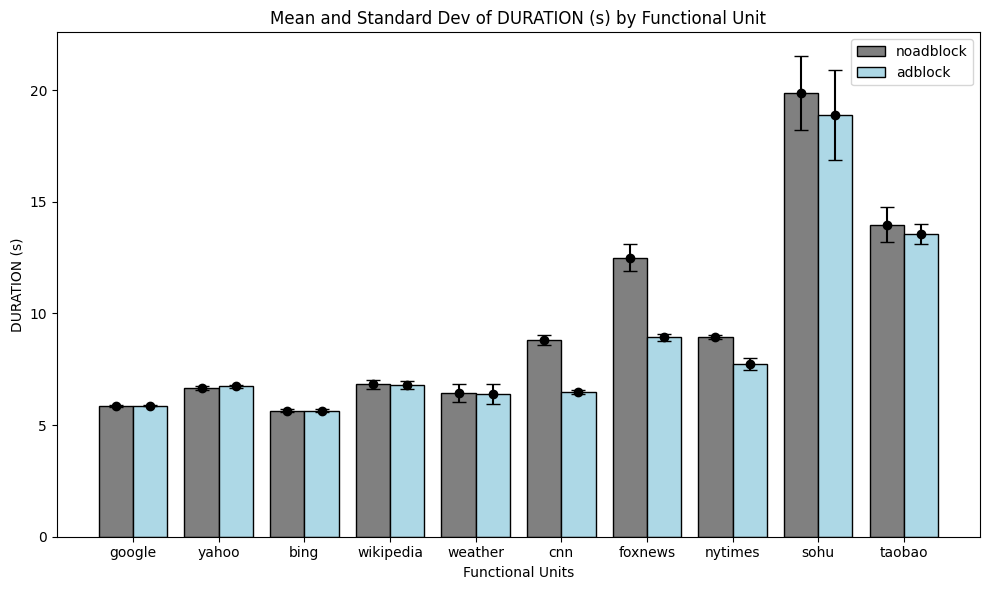

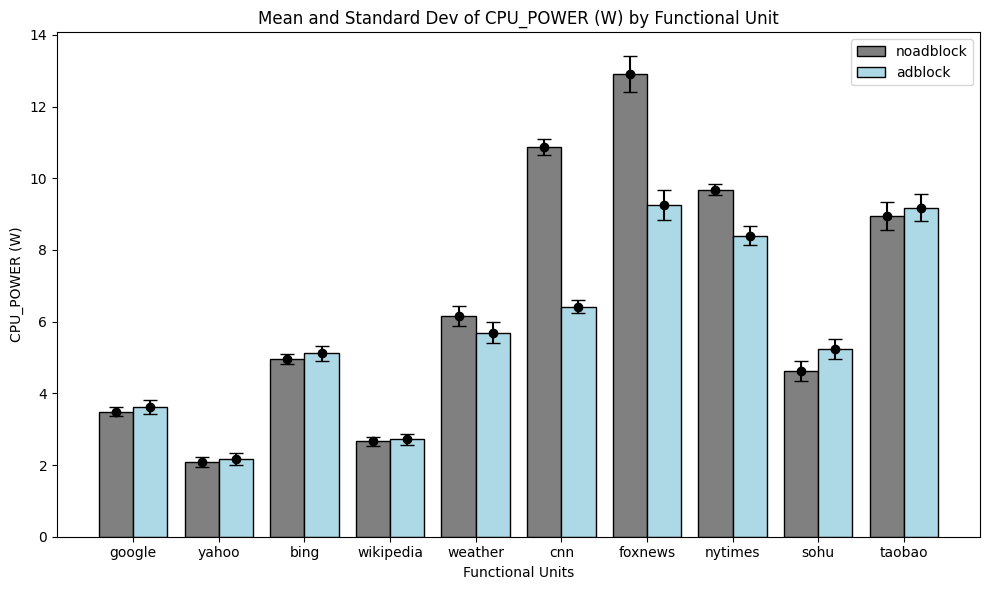

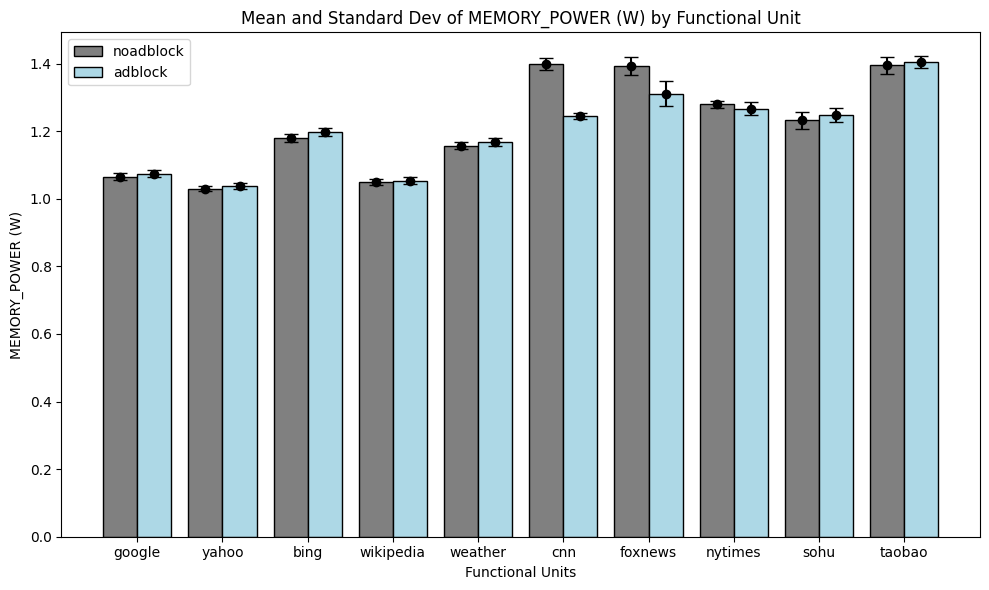

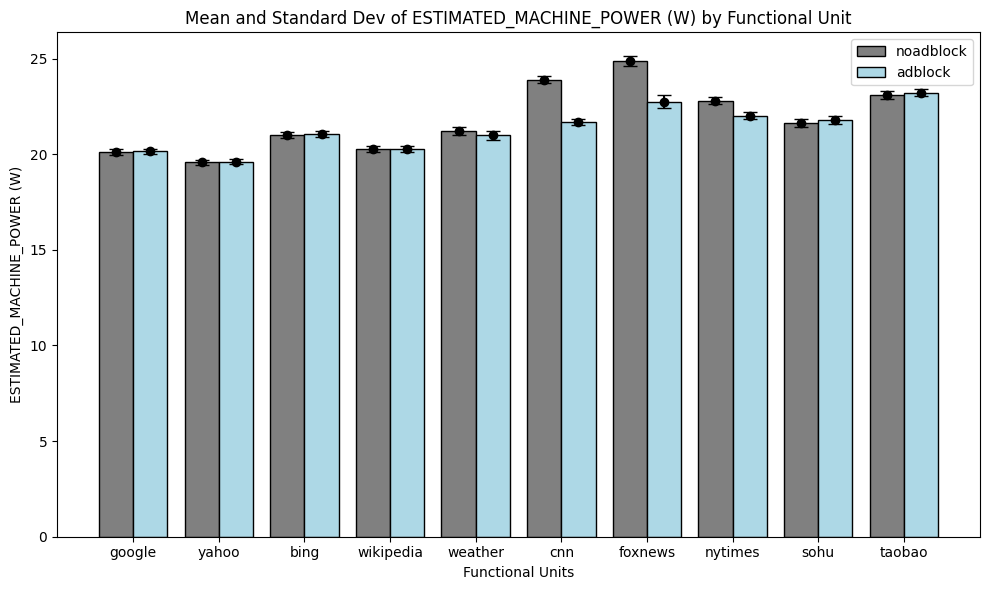

In [75]:
means_and_stds = compute_means_and_stds(clean_data)

for metric in METRICS + COMPUTED_METRICS:
    plot_metrics_bars(means_and_stds, metric)

### Statistical Significance Testing

**Comparing Adblock vs. No-Adblock:**

The function compares each pair of adblock and no-adblock conditions in the DataFrame to assess statistical significance. It uses a paired t-test to determine if the differences in metrics between these conditions are significant.

**Args:**
- `df (pd.DataFrame)`: Contains metrics for each provider and action, with pairs like 'gmail_adblock' and 'gmail_noadblock'.
- `alpha (float)`: Significance level (default is 0.05).

**Returns:**
- `dict`: Results include p-values and significance status for each action and provider.

**Comparing Proton vs. Other Providers (Same Adblock Condition):**

This function evaluates the statistical significance of differences between Proton and other providers (Gmail, Outlook) under the same adblock condition.

**Args:**
- `metric_df (pd.DataFrame)`: Contains metrics for each provider and action.

**Returns:**
- `dict`: Results of significance tests for each action.

In [81]:
def get_samples(data, functional_unit, adblock='disabled',
                columns=METRICS+COMPUTED_METRICS):
    return data[(data['ADBLOCK_CONDITION'] == adblock) &
                (data['FUNCTIONAL_UNIT'] == functional_unit)][columns]


def verify_assumptions_and_perform_test(group_A, group_B, independence):
    """
    Verifies assumptions (normality, homogeneity of variance) and automatically performs 
    the appropriate parametric or non-parametric test using pingouin.

    Args:
    - group_A: Data for the first group.
    - group_B: Data for the second group.
    - independence: Boolean flag to indicate if the groups are independent (True) or dependent (False).

    Returns:
    - test_stat: Test statistic from the statistical test.
    - p_value: p-value from the statistical test.
    """
    
    # Automatically use pingouin to perform the correct t-test or non-parametric test
    if independence:
        result = pg.ttest(group_A, group_B, paired=False, correction="auto")
    else:
        result = pg.ttest(group_A, group_B, paired=True, correction="auto")
    
    p_value = result['p-val'].values[0]
    
    return p_value

def compute_gains(data, comparison_pair, independence, metrics = METRICS+COMPUTED_METRICS):
    """
    Loop over the comparisons and compute statistical test results, 
    applying assumption verification and appropriate statistical tests.
    """

    results = pd.DataFrame(index=metrics, columns=FUNCTIONAL_UNITS)
    percentage_results = pd.DataFrame(index=metrics, columns=FUNCTIONAL_UNITS)

    for functional_unit in FUNCTIONAL_UNITS:
        # Get the data samples for the current comparison
        test_A = get_samples(data, functional_unit, **comparison_pair['A'], columns=metrics)
        test_B = get_samples(data, functional_unit, **comparison_pair['B'], columns=metrics)

        # Ensure both groups have at least one sample
        if len(test_A) > 0 and len(test_B) > 0:

            # If the sizes differ, trim to the size of the smaller group
            min_size = min(len(test_A), len(test_B))
            test_A = test_A.iloc[:min_size]
            test_B = test_B.iloc[:min_size]

            # Perform the statistical test for each metric
            for metric in metrics:

                # Run the assumption check and statistical test
                p_value = verify_assumptions_and_perform_test(test_A[metric], test_B[metric], independence)

                # If the p-value is less than 0.05, compute the gain
                if p_value < 0.05:
                    
                    gain = test_A[metric].mean() - test_B[metric].mean()
                    percentage_gain = 100*(test_A[metric].mean() - test_B[metric].mean())/test_B[metric].mean()

                    results.loc[metric, functional_unit] = gain
                    percentage_results.loc[metric, functional_unit] = percentage_gain
                else:
                    results.loc[metric, functional_unit] = np.nan
                    percentage_results.loc[metric, functional_unit] = np.nan

    return results, percentage_results

def plot_gains(gains: pd.DataFrame, title: str, percentage=False, CO2 = False, label = None, figsize = (10,3)):
    """
    Plots a comparison table for the calculated gain results.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('tight')
    ax.axis('off')

    if percentage :
        units = {metric:'%' for metric, unit in UNITS.items()}
    elif CO2 :
        units = {metric: 'gCO2' if unit == 'J'
                  else 'gCO2' if unit == 'MB' else unit
                  for metric, unit in UNITS.items()}
    else: units = UNITS

    # Function to format the values with "+" or "-" and append the unit
    def format_cell_value(value, unit, sign=True):

        if np.isnan(value):
            return 'Not Significant'
            
        if unit == 'gCO2' and abs(value) > 1e9 :
            value /= 1e9  
            unit = 'ktCO2'
        elif unit == 'gCO2' and abs(value) > 1e6 : 
            value /= 1e6 
            unit = 'tCO2'
        elif unit == 'gCO2' and abs(value) > 1e3 :
            value /= 1e3 
            unit = 'KgCO2'

        # Round the value first
        rounded_value = round(value, 2)

        # If the rounded value is 0, show the original value in scientific notation
        if rounded_value == 0:
            return f"{value:.2e} {unit}"  # Original value in scientific notation
        elif value > 0:
            return f"{'+' if sign else ''}{rounded_value} {unit}"
        elif value < 0:
            return f"{'-' if sign else ''}{abs(rounded_value)} {unit}"
            
            
        return str(value)
    
    colormap = [
                [
                    'lightblue' if col in ['mean', 'std']  # Check if the column is 'mean' or 'std'
                    else 'lightgreen' if isinstance(cell, (int, float)) and cell < 0
                    else 'orange' if isinstance(cell, (int, float)) and cell > 0
                    else 'white'
                    for col, cell in zip(gains.columns, row)
                ]
                for row in gains.values
               ]

    cellText = [
                [   
                    format_cell_value(cell, units.get(metric, ''), sign = False) if col == 'std'
                    else format_cell_value(cell, units.get(metric, ''))
                    for cell, col in zip(row, gains.columns)
                ]
                for metric, row in gains.iterrows()
               ]

    table = ax.table(cellText= cellText,
                     rowLabels=[f"{metric}" for metric in gains.index] if label is None else [label],
                     colLabels=gains.columns,
                     cellLoc='center',
                     loc='center',
                     cellColours=colormap)

    table.auto_set_font_size(True)
    table.set_fontsize(9)
    table.scale(1.5, 1.5)
    plt.title(title, )
    plt.show()

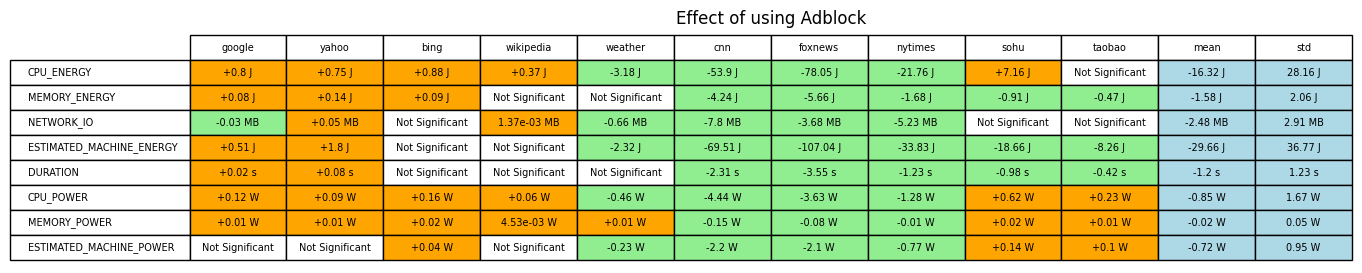

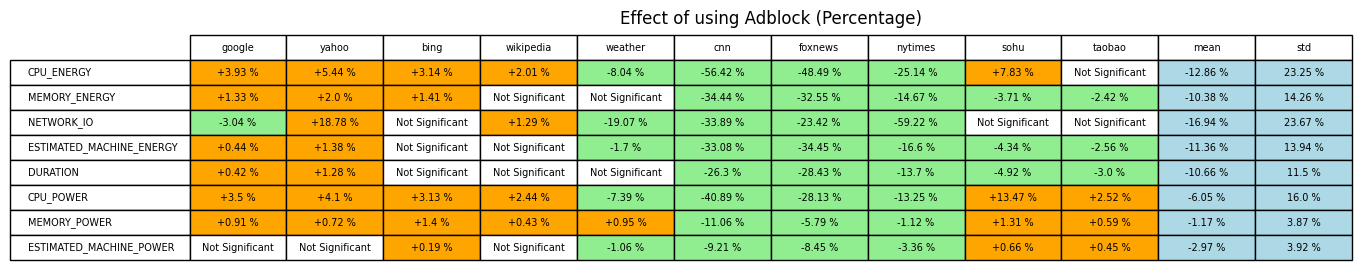

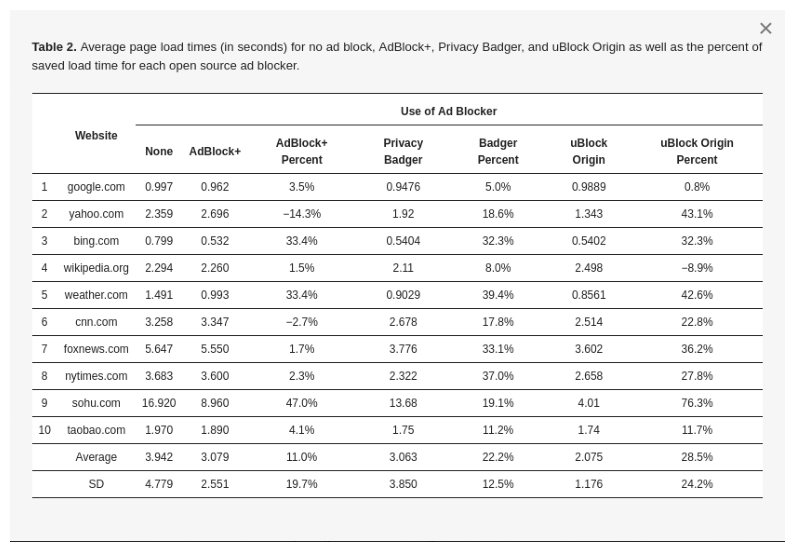

In [92]:
comparisons = {
    "Effect of using Adblock": {
        'A': {'adblock': 'enabled'},
        'B': {'adblock': 'disabled'}
    }
}
for title, comparison_pair in comparisons.items():
    gains, percentage_gains = compute_gains(clean_data, comparison_pair, independence=False)

    # Add mean and std columns to gains and percentage_gains DataFrames
    gains['mean'] = gains.mean(axis=1)
    gains['std'] = gains.std(axis=1)

    percentage_gains['mean'] = percentage_gains.mean(axis=1)
    percentage_gains['std'] = percentage_gains.std(axis=1)
    
    plot_gains(gains, title)
    plot_gains(percentage_gains, title + ' (Percentage)', percentage=True)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img = mpimg.imread('study_stat.png')

# Create a plot
fig, ax = plt.subplots(figsize= (10,10))
ax.imshow(img)
ax.axis('off')
plt.show()




## Here we convert the mean measurment into GHG emissions

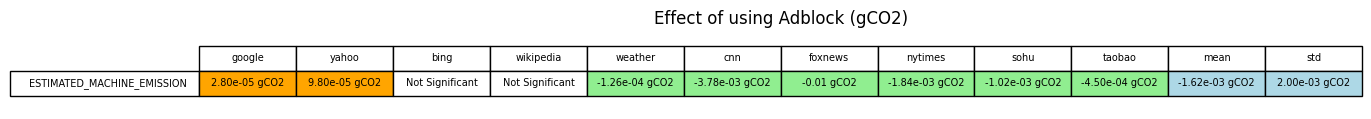

In [93]:
# compute_gains returns dataframe containing strings in some cells ('Not Significant'). So
# we define a safe multiplication function to account for this
def safe_multiply(data: pd.DataFrame, multiplier):
    def multiply_if_number(value, multiplier):
        if isinstance(value, (int, float)):
            return value * multiplier
        else:
            return value
    return data.applymap(lambda x: multiply_if_number(x, multiplier))

e_production_emission = 196*2.7778e-7 #196 [gCO2/kWH] [Belgium2023] * 2.777e-7 [kWh/J] --> [gCO2/J]

for title, comparison_pair in comparisons.items():
    gains, percentage_gains = compute_gains(clean_data, comparison_pair, independence=False, metrics=['ESTIMATED_MACHINE_ENERGY'])
     # Add mean and std columns to gains and percentage_gains DataFrames
    gains['mean'] = gains.mean(axis=1)
    gains['std'] = gains.std(axis=1)
    CO2_USER_gain = safe_multiply(gains, multiplier=e_production_emission)
    plot_gains(CO2_USER_gain, title + ' (gCO2)', CO2=True, label='ESTIMATED_MACHINE_EMISSION', figsize=(10,1))

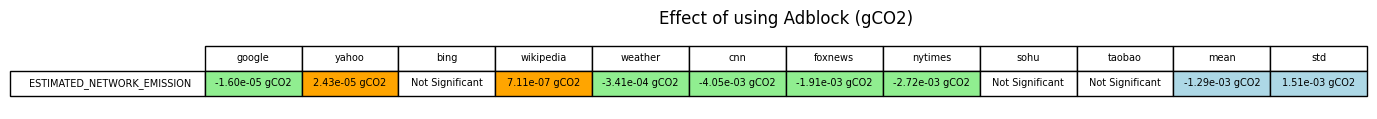

In [84]:
# ratio_network = 186e6*1e6/ (48 * 64871186038784) #186[Megaton] * 106e[g/ton] / (48[ExaByte] * 64 871 186 038 784 [MB/ExaByte])

network_consumption = 0.002652 * 1e-3 # 0.002652 [kWh / GB] * 1e-3 [GB / MB] --> [kWh / MB] see https://www.green-coding.io/co2-formulas/
emissions = 196 # [gCO2 / kWh] Belgium 2025 - see https://app.electricitymaps.com/zone/BE/12mo/monthly
network_emissions = network_consumption * emissions # [gCO2 / MB]

for title, comparison_pair in comparisons.items():
    gains, percentage_gains = compute_gains(clean_data, comparison_pair, independence=False, metrics=['NETWORK_IO'])
     # Add mean and std columns to gains and percentage_gains DataFrames
    gains['mean'] = gains.mean(axis=1)
    gains['std'] = gains.std(axis=1)

    CO2_NETWORK_gain = safe_multiply(gains, network_emissions)
    plot_gains(CO2_NETWORK_gain, title + ' (gCO2)', CO2=True, label='ESTIMATED_NETWORK_EMISSION', figsize=(10,1))

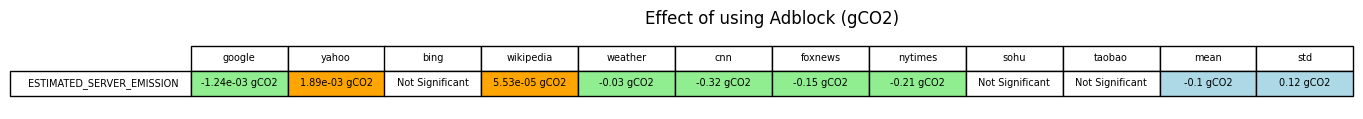

In [94]:
server_emissions = 126*1e12/ (48 * 64871186038784) #126 [MegatonCO2] * 1e12 [gCO2/MegatonCO2] / (48 [ExaByte] * 64 871 186 038 784 [MB/ExaByte]) --> [gCO2/MB]


for title, comparison_pair in comparisons.items():
    gains, percentage_gains = compute_gains(clean_data, comparison_pair, independence= False, metrics=['NETWORK_IO'])
     # Add mean and std columns to gains and percentage_gains DataFrames
    gains['mean'] = gains.mean(axis=1)
    gains['std'] = gains.std(axis=1)
    CO2_SERVER_gain = safe_multiply(gains, server_emissions)
    plot_gains(CO2_SERVER_gain, title + ' (gCO2)', CO2=True, label='ESTIMATED_SERVER_EMISSION', figsize=(10,1))